In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
from scipy.integrate import quad
import pyccl as ccl
import arviz as az
import theano
import theano.tensor as tt
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Make data

In [2]:
rels_dA  = [2.78, 1.87, 1.45, 1.19, 1.01, 0.87, 0.77, 
         0.76, 0.88, 0.91, 0.91, 0.91, 1.00, 1.17, 
         1.50, 2.36, 3.62, 4.79]
rels_H = [5.34, 3.51, 2.69, 2.20, 1.85, 1.60, 1.41, 
         1.35, 1.42, 1.41, 1.38, 1.36, 1.46, 1.66, 
         2.04, 3.15, 4.87, 6.55]

In [3]:
params = {'h': 0.6732,
        'Omega_cdm': 0.265, #0.27
        'Omega_b': 0.050,
        'n_s': 0.9665 }#

#cosmo_ccl = ccl.Cosmology(param_dict)
classy = ccl.boltzmann.classy.Class()
classy.set(params)
classy.compute()

In [4]:
H0 = classy.Hubble(0)
H0

0.00022455534888739598

In [5]:
dz = 0.1
z_arr = np.arange(0.15, 1.85+0.1, dz)

dz_f = 0.01
z_arr_f = np.arange(0.0, 1.85+0.1, dz_f)

In [6]:
print(len(z_arr), len(z_arr_f))

18 195


In [7]:
z_arr

array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15,
       1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85])

In [8]:
idx = np.array([int(x) for x in z_arr/(dz_f)])
z_arr_f[idx]

array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.14,
       1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85])

In [9]:
E100_arr_f = np.array([])
H_arr_f = np.array([])
dA_arr_f = np.array([])
for z in z_arr_f: 
            #We can worry about the rs_drag later
            H = classy.Hubble(z)
            E100 = 100*H/H0
            dA = classy.angular_distance(z)
            dA_arr_f = np.append(dA_arr_f, dA)
            E100_arr_f = np.append(E100_arr_f, E100)
            H_arr_f = np.append(H_arr_f, H)

In [10]:
dA_arr_f2 = dz_f*np.cumsum(1/H_arr_f)/(1+z_arr_f)

In [11]:
E100_arr = E100_arr_f[idx]
H_arr = H_arr_f[idx]
dA_arr = dA_arr_f[idx]

In [12]:
sig_E100_arr = E100_arr*rels_H/100
sig_H_arr = H_arr*rels_H/100
sig_dA_arr = dA_arr*rels_dA/100

In [13]:
ℓ_true = 0.2
η_true = 6
cov_func = η_true ** 2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
mod = np.random.multivariate_normal(
    mean_func(z_arr_f[:, None]).eval(), cov_func(z_arr_f[:, None]).eval() + 1e-8 * np.eye(len(z_arr_f[:, None])), 1
).flatten()

In [14]:
E100_data = (E100_arr_f+mod)[idx] + np.random.randn(len(z_arr))*sig_E100_arr
H_data = E100_data*H0/100
dA_data = (dA_arr_f+10*mod)[idx] + np.random.randn(len(z_arr))*sig_dA_arr

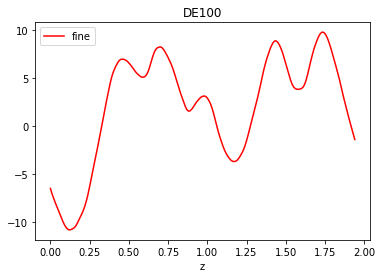

In [15]:
plt.plot(z_arr_f, mod, "r-", label='fine')
#plt.errorbar(z_arr, E100_data, yerr = sig_E100_arr, fmt='ko', label='course')

# axis labels and title
plt.xlabel("z")
plt.title("DE100")
plt.legend();

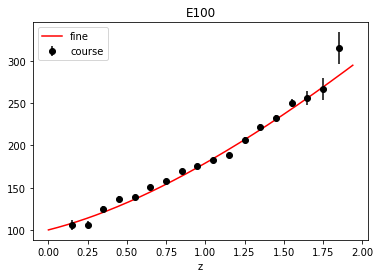

In [16]:
plt.plot(z_arr_f, E100_arr_f, "r-", label='fine')
plt.errorbar(z_arr, E100_data, yerr = sig_E100_arr, fmt='ko', label='course')

# axis labels and title
plt.xlabel("z")
plt.title("E100")
plt.legend();

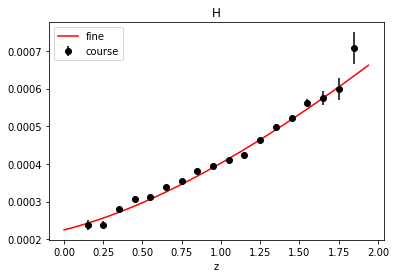

In [17]:
plt.plot(z_arr_f, E100_arr_f*H0/100, "r-", label='fine')
plt.errorbar(z_arr, H_data, yerr = sig_H_arr, fmt='ko', label='course')

# axis labels and title
plt.xlabel("z")
plt.title("H")
plt.legend();

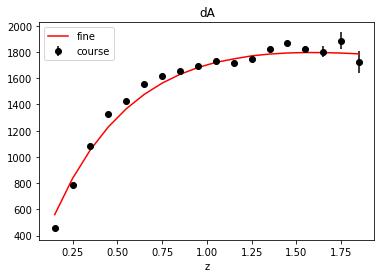

In [18]:
plt.plot(z_arr, dA_arr, "r-", label='fine')
plt.errorbar(z_arr, dA_data, yerr = sig_dA_arr, fmt='ko', label='course')

# axis labels and title
plt.xlabel("z")
plt.title("dA")
plt.legend();

In [19]:
E100_cov = np.zeros([len(z_arr), len(z_arr)])
H_cov = np.zeros([len(z_arr), len(z_arr)])
dA_cov = np.zeros([len(z_arr), len(z_arr)])
for i in np.arange(len(z_arr)):
    E100_cov[i,i] = sig_E100_arr[i]**2
    H_cov[i,i] = sig_H_arr[i]**2
    dA_cov[i,i] = sig_dA_arr[i]**2

# Pymc3

In [20]:
with pm.Model() as model:
    ℓ = pm.Uniform("ℓ", 0., 1.) 
    η = pm.Uniform("η", 0, 8) 
    gp_cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ) + pm.gp.cov.WhiteNoise(1e-3)
    gp = pm.gp.Latent(cov_func=gp_cov)
    
    DE100_gp_f = gp.prior("DE100_gp_f", X=z_arr_f[:, None])
    E100_gp_f = pm.Deterministic("E100_gp_f", tt.as_tensor_variable(DE100_gp_f+E100_arr_f)) 
    H_gp_f = pm.Deterministic("H_gp_f", tt.as_tensor_variable(E100_gp_f*H0/100))  
    dH_gp_f = pm.Deterministic("dH_gp_f", tt.as_tensor_variable(1/H_gp_f))
    dA_gp_f = tt.zeros(len(z_arr_f))
    dA_gp_f = tt.inc_subtensor(dA_gp_f[0], 0)
    dA_gp_f = tt.inc_subtensor(dA_gp_f[1:],
              tt.as_tensor_variable((dz_f*tt.cumsum(dH_gp_f)/(1+z_arr_f))[1:]))
    dA_gp_f = pm.Deterministic('dA_gp_f', dA_gp_f)
    
    idx = np.array([int(x) for x in z_arr/dz_f])
    E100_gp = pm.Deterministic('E100_gp', tt.as_tensor_variable(E100_gp_f[idx]))
    H_gp = pm.Deterministic('H_gp', tt.as_tensor_variable(H_gp_f[idx]))
    dA_gp = pm.Deterministic('dA_gp', tt.as_tensor_variable(dA_gp_f[idx]))
    
    samples = pm.sample_prior_predictive(samples=1, var_names=["dA_gp", "H_gp"])
    print(samples)
    
    #lkl = pm.MvNormal("H_obs", mu=H_gp, cov=H_cov, observed=H_data)
    #lkl = pm.MvNormal("E100_obs", mu=E100_gp, cov=E100_cov, observed=E100_data)
    lkl = pm.MvNormal("dA_obs", mu=dA_gp, cov=dA_cov, observed=dA_data)
    
    trace = pm.sample(200, chains=1, cores=1, return_inferencedata=True, tune=300)#, target_accept=0.95, init = 'map')

{'dA_gp': array([[ 663.3086484 ,  954.68002455, 1178.49493623, 1350.26957181,
        1482.27854366, 1584.16439237, 1662.84223456, 1723.05695386,
        1768.47954131, 1802.02445153, 1823.99210053, 1842.29836987,
        1852.35653307, 1857.2246461 , 1857.7238381 , 1854.58019946,
        1848.45558422, 1839.95434161]]), 'H_gp': array([[0.00022253, 0.00024071, 0.00026088, 0.00028245, 0.00030441,
        0.00032587, 0.00034779, 0.00037055, 0.00039409, 0.00041811,
        0.00044017, 0.00046735, 0.00049268, 0.00051948, 0.00054767,
        0.0005769 , 0.0006065 , 0.00063603]])}


Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [DE100_gp_f_rotated_, η, ℓ]


Sampling 1 chain for 300 tune and 200 draw iterations (300 + 200 draws total) took 132 seconds.
The acceptance probability does not match the target. It is 0.8860108686747725, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


<ipython-input-21-e1138b7d907f>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  fig = pm.traceplot(trace)
/home/jaimerz/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/home/jaimerz/.local/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5


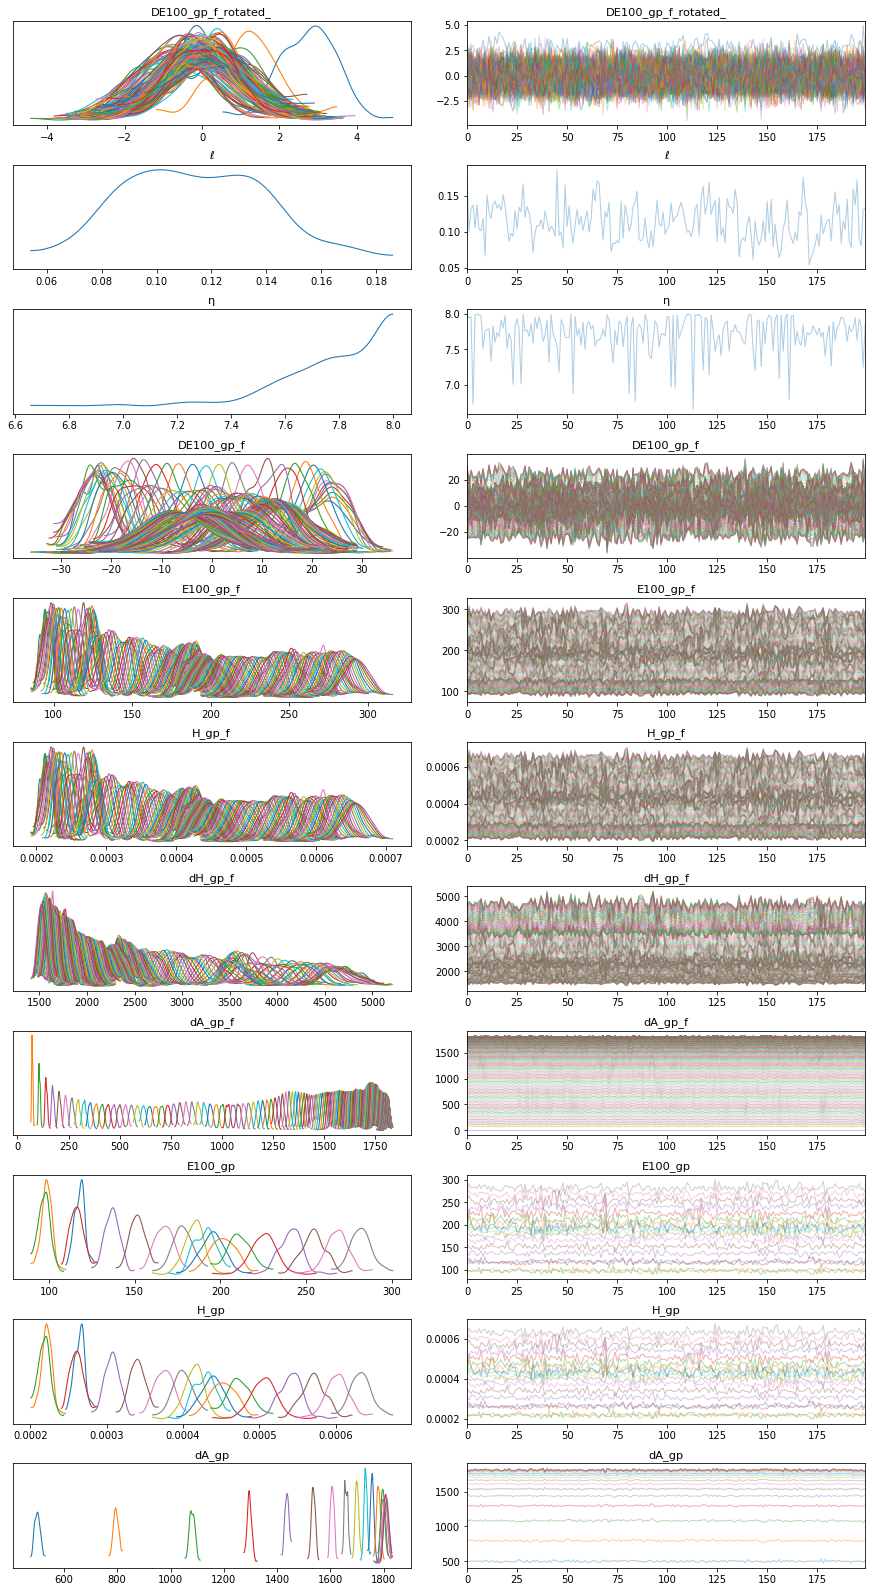

In [21]:
fig = pm.traceplot(trace)

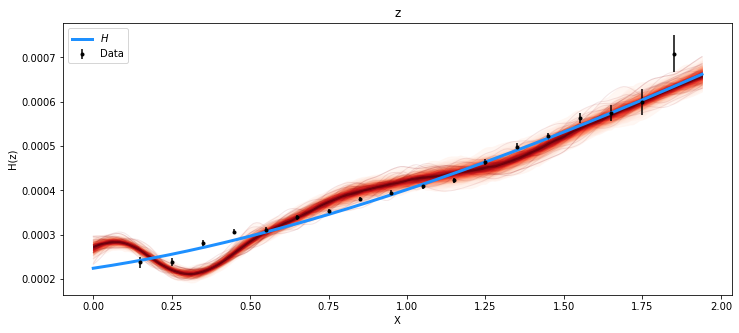

In [22]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["H_gp_f"][0, :, :], z_arr_f[:, None])

# plot the data and the true latent function
ax.plot(z_arr_f[:, None], H_arr_f, "dodgerblue", lw=3, label=r'$H$')
ax.errorbar(z_arr[:, None], H_data, yerr=sig_H_arr, fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("H(z)")
plt.title("z")
plt.legend();

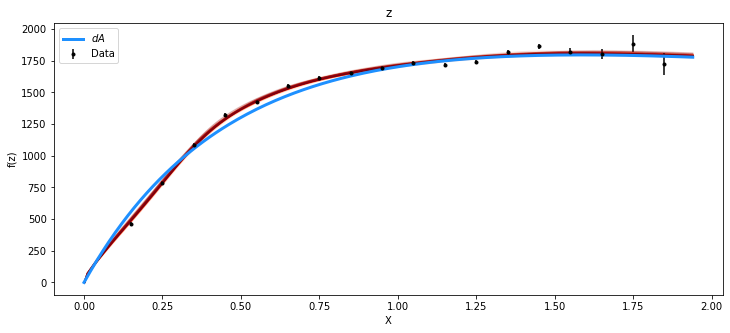

In [23]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, trace.posterior["dA_gp_f"][0, :, :], z_arr_f[:, None])

# plot the data and the true latent function
ax.plot(z_arr_f[:, None], dA_arr_f, "dodgerblue", lw=3, label=r'$dA$')
ax.errorbar(z_arr[:, None], dA_data, yerr=sig_dA_arr, fmt="ok", ms=3, label="Data")

# axis labels and title
plt.xlabel("X")
plt.ylabel("f(z)")
plt.title("z")
plt.legend();

In [24]:
#z_new
# add the GP conditional to the model, given the new X values
z_new_f = np.arange(0.0, 3+0.1, dz_f)[:, None]
with model:
    DE100_pred_f = gp.conditional("DE100_pred_f", z_new_f)

# Sample from the GP conditional distribution
with model:
    pred_samples_f = pm.sample_posterior_predictive(trace.posterior, samples=1000, var_names=["DE100_pred_f"])

No handles with labels found to put in legend.


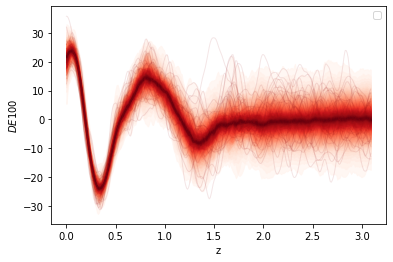

In [25]:
# plot the results
fig = plt.figure()
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples_f["DE100_pred_f"], z_new_f)

# axis labels and title
plt.xlabel("z")
plt.ylabel(r'$DE100$')
#plt.ylim([-1.3, 4])
#plt.xlim([0, 3])
plt.legend();

In [26]:
H_new_f = np.array([])
for z in z_new_f:
    H = classy.Hubble(z)
    H_new_f = np.append(H_new_f, H)

E100_new_f = 100*H_new_f/H0

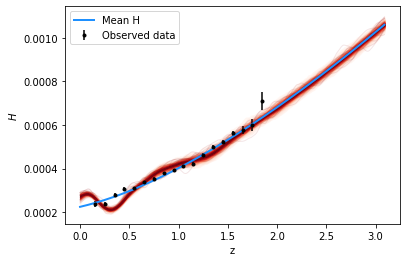

In [27]:
# plot the results
fig = plt.figure()
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, (pred_samples_f["DE100_pred_f"]+E100_new_f)*H0/100, z_new_f)
# plot the data and the true latent function
plt.plot(z_new_f, H_new_f, "dodgerblue", lw=2, label="Mean H")
ax.errorbar(z_arr[:, None], H_data , yerr=sig_H_arr, fmt="ok", ms=3, label="Observed data")

# axis labels and title
plt.xlabel("z")
plt.ylabel(r'$H$')
#plt.ylim([-1.3, 4])
#plt.xlim([0, 3])
plt.legend();

In [28]:
H_samples = (pred_samples_f["DE100_pred_f"]+E100_new_f)*H0/100
np.savetxt('H_samples.txt', H_samples)

In [30]:
import os
os.path.join('fff', 'ggg')

'fff/ggg'

In [31]:
import classy

In [ ]:
classy.